### Incremental Review Scraping with Deduplication and Checkpointing

In [1]:
from google_play_scraper import Sort, reviews
import pandas as pd
from pathlib import Path
import time
import random
import pickle

APP_ID = "com.openai.chatgpt"
DATA_FILE = Path("play_reviews_ingested.csv")
TOKEN_FILE = DATA_FILE.with_suffix(".token.pkl")


def load_existing_ids_and_token():
    """
    Resumable crawling:
    - If CSV exists, load review_id for deduplication
    - Load continuation_token from a pickle file (keeps original object structure)
    """
    existing_ids = set()

    if DATA_FILE.exists():
        df = pd.read_csv(DATA_FILE)
        if "review_id" in df.columns:
            existing_ids = set(df["review_id"].astype(str))

    token = None
    if TOKEN_FILE.exists():
        with open(TOKEN_FILE, "rb") as f:
            token = pickle.load(f)

        # Safety: if token is accidentally saved as string, discard it
        if isinstance(token, str):
            token = None

    return existing_ids, token


def save_token(token):
    """Persist continuation_token (as-is) via pickle for checkpointing"""
    with open(TOKEN_FILE, "wb") as f:
        pickle.dump(token, f)


def append_rows_to_csv(rows):
    """Append new review rows to CSV with schema normalization"""
    if not rows:
        return

    df_new = pd.DataFrame(rows)

    # Normalize column names (fields may vary slightly by library version)
    rename_map = {
        "reviewId": "review_id",
        "userName": "user_name",
        "content": "content",
        "score": "score",
        "at": "at",
        "replyContent": "reply_content",
        "repliedAt": "replied_at",
        "thumbsUpCount": "thumbs_up_count",
        "appVersion": "app_version",
    }
    df_new = df_new.rename(columns=rename_map)

    # Ensure review_id exists and is a string
    if "review_id" not in df_new.columns and "reviewId" in df_new.columns:
        df_new["review_id"] = df_new["reviewId"].astype(str)
    if "review_id" in df_new.columns:
        df_new["review_id"] = df_new["review_id"].astype(str)

    # Append mode (write header only if file does not exist)
    write_header = not DATA_FILE.exists()
    df_new.to_csv(DATA_FILE, mode="a", header=write_header, index=False)


def fetch_reviews(target_new=10000, per_call=200, max_total_calls=2000):
    """
    Incrementally fetch Google Play reviews.

    Parameters:
    - target_new: number of new (unseen) reviews to collect this run
    - per_call: number of reviews per API call
    - max_total_calls: safety cap on total calls
    """
    existing_ids, continuation_token = load_existing_ids_and_token()
    new_rows_buffer = []
    new_count = 0

    start_time = time.time()
    calls = 0
    seen_existing_streak = 0

    print(f"[START] existing reviews: {len(existing_ids):,}")
    print(f"[START] target new reviews: {target_new:,}")
    print(f"[START] resume token: {'Y' if continuation_token else 'N'}")

    while new_count < target_new and calls < max_total_calls:
        calls += 1
        t0 = time.time()

        try:
            result, continuation_token = reviews(
                APP_ID,
                lang="en",
                country="us",
                sort=Sort.NEWEST,
                count=per_call,
                continuation_token=continuation_token,
            )
        except Exception as e:
            # Simple retry with backoff
            wait_s = 2 + random.random() * 2
            print(f"[WARN] call #{calls} failed: {e} | retry after {wait_s:.1f}s")
            time.sleep(wait_s)
            continue

        fetched = len(result)
        added_this_call = 0

        for r in result:
            rid = str(r.get("reviewId") or r.get("review_id") or "")
            if not rid:
                continue
            if rid in existing_ids:
                continue

            existing_ids.add(rid)
            new_rows_buffer.append(r)
            new_count += 1
            added_this_call += 1

            # Flush to disk in batches to avoid memory growth and data loss
            if len(new_rows_buffer) >= 500:
                append_rows_to_csv(new_rows_buffer)
                new_rows_buffer.clear()
                save_token(continuation_token)

            if new_count >= target_new:
                break

        # Track consecutive calls that add 0 new reviews
        if added_this_call == 0:
            seen_existing_streak += 1
        else:
            seen_existing_streak = 0

        dt = time.time() - t0
        elapsed = time.time() - start_time
        rate = new_count / elapsed if elapsed > 0 else 0

        print(
            f"[{calls:04d}] fetched={fetched:3d} added={added_this_call:3d} "
            f"total_new={new_count:,} token={'Y' if continuation_token else 'N'} "
            f"dt={dt:.2f}s rate={rate:.2f}/s"
        )

        # Stop if we keep getting only duplicates (likely saturated/paging loop)
        if seen_existing_streak >= 20:
            print("[STOP] too many consecutive calls with 0 new reviews (likely saturated or paging loop).")
            break

        # Mild randomized sleep to avoid aggressive request pattern
        time.sleep(0.3 + random.random() * 0.3)

        # No token means no more pages
        if not continuation_token:
            print("[STOP] continuation_token is None (no more pages).")
            break

    # Final flush
    if new_rows_buffer:
        append_rows_to_csv(new_rows_buffer)
        new_rows_buffer.clear()
        save_token(continuation_token)

    total_elapsed = time.time() - start_time
    print(f"[DONE] new added: {new_count:,} | total elapsed: {total_elapsed/60:.1f} min")
    print(f"[DONE] saved to: {DATA_FILE.resolve()}")
    print(f"[DONE] token saved to: {TOKEN_FILE.resolve()}")


# Run example: fetch 10,000 new reviews
fetch_reviews(target_new=10000, per_call=200)


[START] existing reviews: 16,880
[START] target new reviews: 10,000
[START] resume token: Y
[0001] fetched=  0 added=  0 total_new=0 token=Y dt=30.39s rate=0.00/s
[0002] fetched=  0 added=  0 total_new=0 token=Y dt=0.00s rate=0.00/s
[0003] fetched=  0 added=  0 total_new=0 token=Y dt=0.00s rate=0.00/s
[0004] fetched=  0 added=  0 total_new=0 token=Y dt=0.00s rate=0.00/s
[0005] fetched=  0 added=  0 total_new=0 token=Y dt=0.00s rate=0.00/s
[0006] fetched=  0 added=  0 total_new=0 token=Y dt=0.00s rate=0.00/s
[0007] fetched=  0 added=  0 total_new=0 token=Y dt=0.00s rate=0.00/s
[0008] fetched=  0 added=  0 total_new=0 token=Y dt=0.00s rate=0.00/s
[0009] fetched=  0 added=  0 total_new=0 token=Y dt=0.00s rate=0.00/s
[0010] fetched=  0 added=  0 total_new=0 token=Y dt=0.00s rate=0.00/s
[0011] fetched=  0 added=  0 total_new=0 token=Y dt=0.00s rate=0.00/s
[0012] fetched=  0 added=  0 total_new=0 token=Y dt=0.00s rate=0.00/s
[0013] fetched=  0 added=  0 total_new=0 token=Y dt=0.00s rate=0.00

### Check Data Shape

After implementing a resumable ingestion pipeline, I validated the dataset by checking its shape, schema consistency, and sample records to ensure data integrity before downstream analysis.

In [2]:
import pandas as pd

df = pd.read_csv(r"play_reviews_ingested.csv")
print("shape:", df.shape)
print("columns:", df.columns.tolist())
df.head(3)


shape: (16880, 11)
columns: ['review_id', 'user_name', 'user_image_url', 'review_text', 'rating', 'thumbs_up', 'review_created_version', 'review_time', 'reply_text', 'reply_time', 'app_version']


,review_id,user_name,user_image_url,review_text,rating,thumbs_up,review_created_version,review_time,reply_text,reply_time,app_version
0,2876fe36-e40d-45e4-98c6-509d937232a9,Mahakal Gulshan Sharma,https://play-lh.googleusercontent.com/a-/ALV-U...,radhe radhe,3,0,NaN,2025-12-29 10:43:25,NaN,NaN,NaN
1,f45da16f-dd83-4224-8093-d857a616afb9,Donthi Naresh,https://play-lh.googleusercontent.com/a/ACg8oc...,super,5,0,1.2025.350,2025-12-29 10:41:40,NaN,NaN,1.2025.350
2,6af6aec0-a07b-4ffc-8b27-5231ebf1ff23,Royrex Ndlovu,https://play-lh.googleusercontent.com/a-/ALV-U...,ultra super app,5,0,1.2025.350,2025-12-29 10:41:21,NaN,NaN,1.2025.350


### Data Preprocessing and Basic Feature Engineering


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data
df = pd.read_csv(r"play_reviews_ingested.csv")

print("Rows:", len(df))
print(df.columns.tolist())

# ---------- Basic type cleaning ----------
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

df["review_time"] = pd.to_datetime(
    df["review_time"],
    errors="coerce"
)

df["review_text"] = df["review_text"].astype(str)

# ---------- Text length features ----------
df["review_len"] = df["review_text"].str.len()
df["word_count"] = df["review_text"].str.split().str.len()

# ---------- Missing value check ----------
print("\nMissing rate:")
print(df[["rating", "review_time", "review_len"]].isna().mean())

Rows: 16880
['review_id', 'user_name', 'user_image_url', 'review_text', 'rating', 'thumbs_up', 'review_created_version', 'review_time', 'reply_text', 'reply_time', 'app_version']

Missing rate:
rating         0.0
review_time    0.0
review_len     0.0
dtype: float64


### Descriptive Statistics and Rating Distribution

             rating    review_len    word_count
count  16880.000000  16880.000000  16880.000000
mean       4.515581     31.231398      6.075355
std        1.091737     61.976161     11.319253
min        1.000000      1.000000      1.000000
25%        5.000000      6.000000      1.000000
50%        5.000000     11.000000      2.000000
75%        5.000000     28.000000      5.000000
max        5.000000    500.000000    117.000000


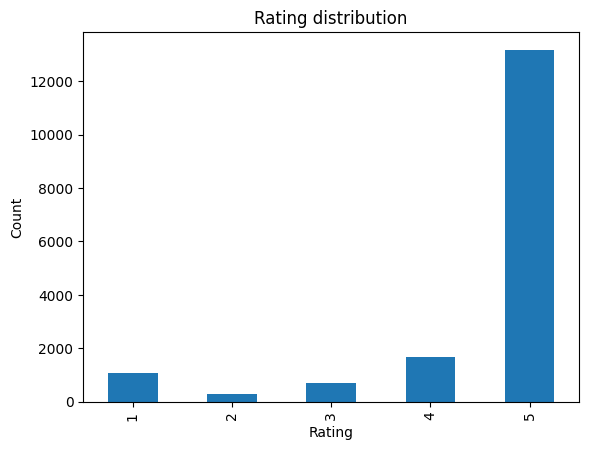

In [4]:
# Descriptive statistics 
print(
    df[["rating", "review_len", "word_count"]]
    .describe()
)

# Rating distribution
plt.figure()
df["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Rating distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


### Temporal Analysis of Ratings (Hourly Trends)

min: 2025-12-29 09:18:25
max: 2026-01-06 10:08:35
unique days: 7
unique weeks: 2
Hourly points: 129
hour
2025-12-29 09:00:00    4.650000
2025-12-29 10:00:00    4.470000
2026-01-01 04:00:00    4.577778
2026-01-01 05:00:00    4.433333
2026-01-01 06:00:00    4.500000
Name: rating, dtype: float64


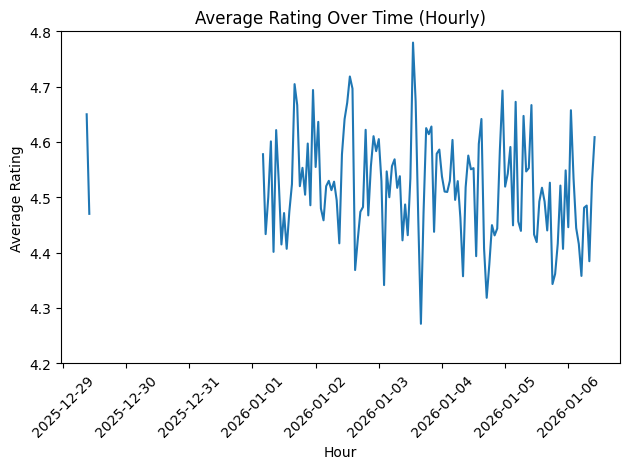

In [5]:
import matplotlib.pyplot as plt

# Convert review_time to datetime format
df["review_time"] = pd.to_datetime(df["review_time"], errors="coerce")

# Inspect the temporal coverage of the dataset
print("min:", df["review_time"].min())
print("max:", df["review_time"].max())
print("unique days:", df["review_time"].dt.date.nunique())
print("unique weeks:", df["review_time"].dt.to_period("W").nunique())

# Keep only rows with valid timestamps and ratings
df_time = df.dropna(subset=["review_time", "rating"]).copy()

# Aggregate ratings at an hourly level
df_time["hour"] = df_time["review_time"].dt.floor("h")
hourly_avg = df_time.groupby("hour")["rating"].mean()

# Inspect the number of hourly data points
print("Hourly points:", len(hourly_avg))
print(hourly_avg.head())

# Create a complete hourly time index to avoid misleading line connections
full_hours = pd.date_range(
    start=hourly_avg.index.min(),
    end=hourly_avg.index.max(),
    freq="h"
)

# Reindex to the full hourly range
hourly_avg = hourly_avg.reindex(full_hours)

# Plot the hourly average rating over time
plt.figure()
plt.plot(hourly_avg.index, hourly_avg.values, linestyle="-")
plt.title("Average Rating Over Time (Hourly)")
plt.xlabel("Hour")
plt.ylabel("Average Rating")
plt.ylim(4.2, 4.8)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Relationship Between Review Length and Rating

<Figure size 640x480 with 0 Axes>

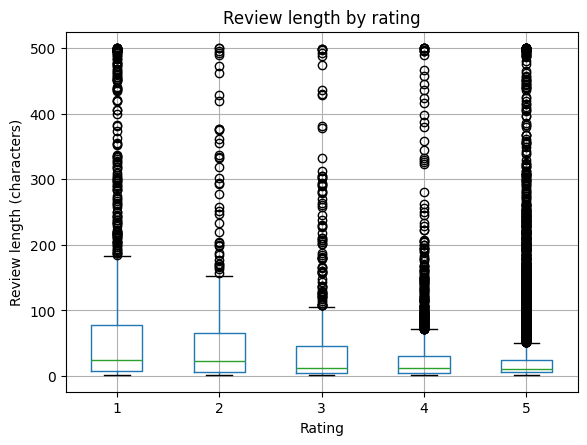

In [6]:
plt.figure()
df.boxplot(column="review_len", by="rating")
plt.suptitle("")
plt.title("Review length by rating")
plt.xlabel("Rating")
plt.ylabel("Review length (characters)")
plt.show()


### Rating Comparison Across App Versions

Top app versions summary:
                 n  avg_rating    avg_len
app_version                              
1.2025.350   13985    4.548016  30.385842
1.2025.343     553    4.546112  22.864376
1.2025.336     325    4.563077  24.923077
1.2025.329     232    4.431034  31.099138
1.2025.322     114    4.587719  28.350877
1.2025.308      85    4.611765  25.129412
1.2025.315      74    4.594595  28.054054
1.2025.302      72    4.430556  29.763889
1.2025.294      46    4.630435  32.695652
1.2025.283      34    4.441176  31.823529


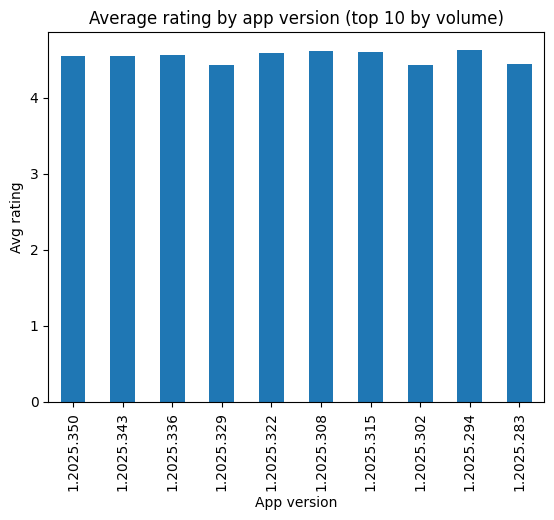

In [7]:
# Keep only rows with both app version and rating available
dv = df.dropna(subset=["app_version", "rating"]).copy()

# Focus on the top app versions by review volume
top_versions = dv["app_version"].value_counts().head(10).index
dv = dv[dv["app_version"].isin(top_versions)]

# Compute summary statistics by app version
version_stats = (
    dv.groupby("app_version")
      .agg(
          n=("rating", "size"),
          avg_rating=("rating", "mean"),
          avg_len=("review_len", "mean")
      )
      .sort_values("n", ascending=False)
)

print("Top app versions summary:")
print(version_stats)

# Plot average rating by app version
plt.figure()
version_stats["avg_rating"].plot(kind="bar")
plt.title("Average rating by app version (top 10 by volume)")
plt.xlabel("App version")
plt.ylabel("Avg rating")
plt.show()


In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

sia = SentimentIntensityAnalyzer()

df = pd.read_csv(r"play_reviews_ingested.csv")

df["sentiment"] = df["review_text"].astype(str).apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

df[["rating", "sentiment"]].head()


,rating,sentiment
0,3,0.0000
1,5,0.5994
2,5,0.5994
3,5,0.6249
4,1,0.0000


<Figure size 640x480 with 0 Axes>

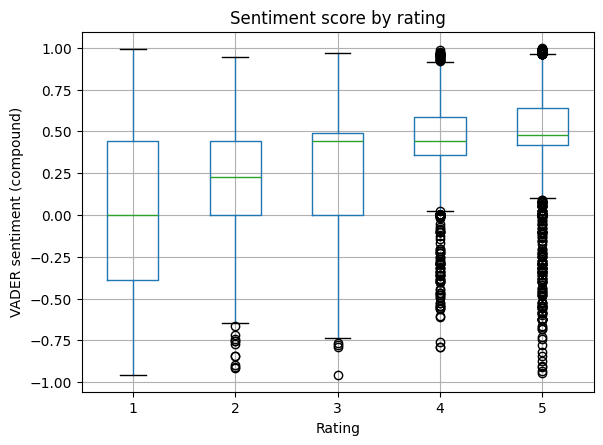

In [10]:
import matplotlib.pyplot as plt

plt.figure()
df.boxplot(column="sentiment", by="rating")
plt.suptitle("")
plt.title("Sentiment score by rating")
plt.xlabel("Rating")
plt.ylabel("VADER sentiment (compound)")
plt.show()


In [11]:
sentiment_by_rating = df.groupby("rating")["sentiment"].mean()
print(sentiment_by_rating)


rating
1    0.000228
2    0.185206
3    0.299668
4    0.405418
5    0.454126
Name: sentiment, dtype: float64


In [12]:
low_df = df[df["rating"].isin([1, 2])].copy()
print("Low-rating reviews:", len(low_df))


Low-rating reviews: 1357


In [17]:
from nltk.corpus import stopwords
from nltk.util import bigrams
from collections import Counter
import re
import nltk

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

low_df = df[df["rating"].isin([1, 2])].copy()

def clean_text(text):
    tokens = re.sub(r"[^a-zA-Z\s]", "", text.lower()).split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return tokens

bigrams_list = []
for text in low_df["review_text"]:
    tokens = clean_text(text)
    bigrams_list.extend(list(bigrams(tokens)))

bigram_counts = Counter(bigrams_list)
bigram_counts.most_common(20)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\y8qia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[(('chat', 'gpt'), 39),
 (('good', 'app'), 16),
 (('worst', 'app'), 16),
 (('bad', 'app'), 13),
 (('wrong', 'information'), 12),
 (('nice', 'app'), 11),
 (('dont', 'use'), 11),
 (('please', 'fix'), 10),
 (('dont', 'download'), 10),
 (('best', 'app'), 9),
 (('gives', 'wrong'), 9),
 (('app', 'hai'), 9),
 (('wrong', 'answers'), 9),
 (('waste', 'time'), 8),
 (('cant', 'even'), 8),
 (('download', 'app'), 7),
 (('bekar', 'hai'), 7),
 (('doesnt', 'work'), 7),
 (('app', 'good'), 7),
 (('dont', 'like'), 7)]

 ### Sentiment Analysis with VADER and Alignment with Ratings

In [18]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

df["sentiment"] = df["review_text"].apply(
    lambda x: sia.polarity_scores(x)["compound"]
)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\y8qia\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<Figure size 640x480 with 0 Axes>

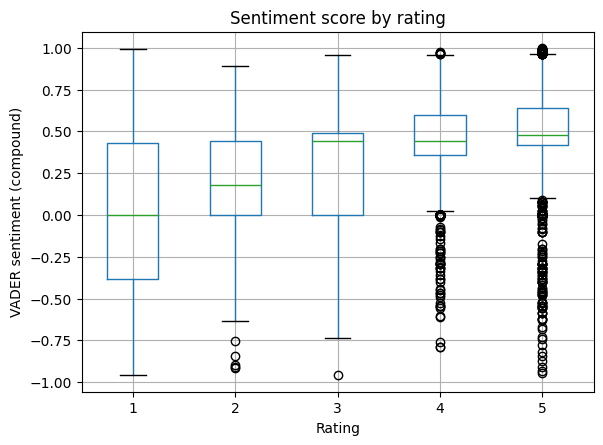

rating
1   -0.014019
2    0.170092
3    0.290376
4    0.402492
5    0.455445
Name: sentiment, dtype: float64


In [ ]:
plt.figure()
df.boxplot(column="sentiment", by="rating")
plt.suptitle("")
plt.title("Sentiment score by rating")
plt.xlabel("Rating")
plt.ylabel("VADER sentiment (compound)")
plt.show()

sentiment_by_rating = df.groupby("rating")["sentiment"].mean()
print(sentiment_by_rating)
